#### Exercise 10 - Solution - Synthetic Control Using Lasso

An e-commerce company operating in 10 different regions implemented a new marketing strategy in a single test region (Region 5) starting October 1 2024 continuing indefinitely. As we've generated the data ourselves, we know the ground truth is that the treatment increased revenue in that region by 20% over what it would have been if not for the change. 

Your goal is to build a synthetic control model that reasonably reflects this increase. 

In [9]:
import pandas as pd
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 

In [10]:
df = pd.read_csv("../data/synthetic_control_revenue_data.csv", date_parser=True)
df.head()

/var/folders/f0/jvljfjlj3bxdhpqmfbcnfsbm0000gn/T/ipykernel_3688/1772449537.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("../data/synthetic_control_revenue_data.csv", date_parser=True)


,Month,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9,Region 10
0,2023-01-01,9322.565026,10763.201411,8379.885931,9258.455623,9450.947929,10437.677905,10060.643647,9985.189491,9328.222526,9639.947623
1,2023-02-01,9737.938268,11701.398724,11241.961029,10991.843109,10222.822882,10700.643686,10281.504076,10915.543547,10560.931888,11581.508977
2,2023-03-01,11287.917691,11792.099443,11363.351753,9207.389538,10847.371295,11319.571857,12205.977940,12243.919931,10102.988763,11022.111375
3,2023-04-01,12584.751131,12967.746822,12867.541821,11259.416674,11975.964764,12603.817098,11528.820985,11631.156162,11660.287992,12052.554474
4,2023-05-01,11816.404647,11426.054667,11258.764335,11598.348889,11540.803870,12154.049899,10765.484396,12401.222295,11194.799213,11972.444224


In [11]:
# Set parameters 
treated_region = "Region 5"
control_regions = [col for col in df.columns if col.startswith("Region") and col != treated_region]
event_start = "2024-10-01" 


In [12]:
# Estimate a Lasso regression model using pre-treatment data 
preperiod = df[df["Month"] < event_start] 

lasso_model = LassoCV(cv=5).fit(preperiod[control_regions], preperiod[treated_region])

# Get the coefficients from the Lasso model
lasso_coefficients = pd.Series(lasso_model.coef_, index=control_regions)
print(lasso_coefficients)

Region 1     0.499141
Region 2     0.000000
Region 3     0.001292
Region 4     0.298641
Region 6     0.000303
Region 7     0.198430
Region 8     0.000000
Region 9     0.000000
Region 10    0.000083
dtype: float64


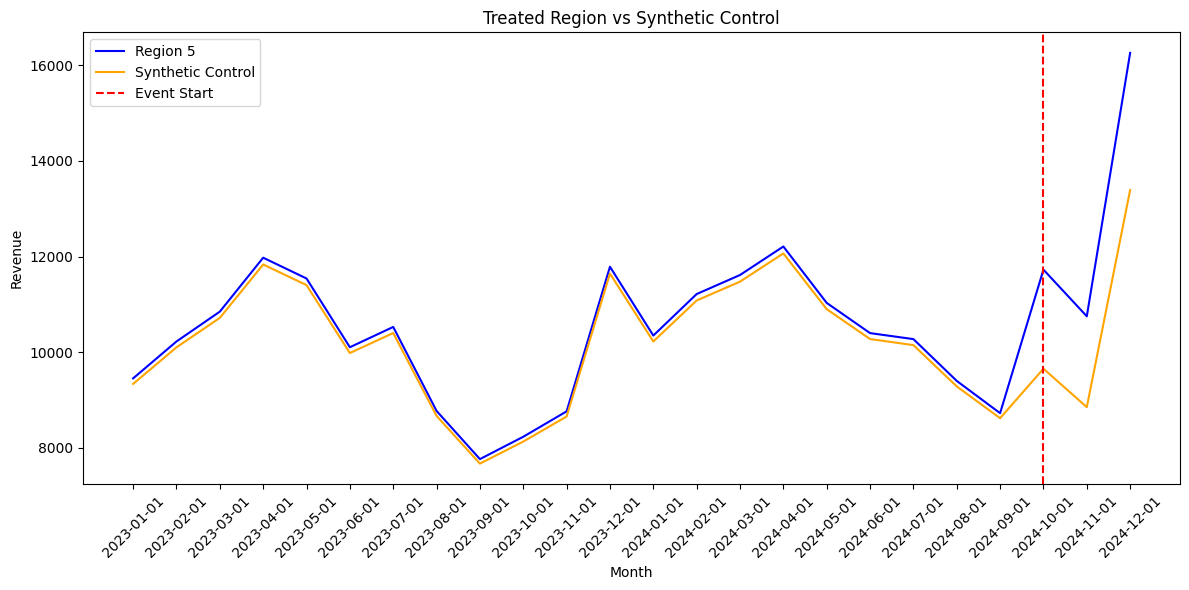

In [13]:
# Use the coefficients to estimate the synthetic control for the entire period 

df["Synthetic Control"] = df[control_regions].dot(lasso_coefficients)

offset_for_plot = 0.99

# Plot the treated region and synthetic control
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df["Month"], df[treated_region], label=treated_region, color='blue')
plt.plot(df["Month"], df["Synthetic Control"]*offset_for_plot, label="Synthetic Control", color='orange')
plt.axvline(event_start, color='red', linestyle='--', label='Event Start')
plt.title("Treated Region vs Synthetic Control")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Estimate the treatment effect by comparing the treated region to the synthetic control
df["Treatment Effect"] = df[treated_region] - df["Synthetic Control"]

postperiod = df[df["Month"] >= event_start]
print("Post-treatment period treatment effect:")
print(postperiod["Treatment Effect"].mean())
print(postperiod["Treatment Effect"].mean() / (postperiod["Synthetic Control"].mean()))


Post-treatment period treatment effect:
2173.775216224276
0.2024229527893141


In [15]:
# Model the treatment effect using a difference-in-differences approach
treated_df = df[["Month", treated_region]].rename(columns={treated_region: "Revenue"})
treated_df["treated"] = 1

control_df = df[["Month", "Synthetic Control"]].rename(columns={"Synthetic Control": "Revenue"})
control_df["treated"] = 0
stacked_df = pd.concat([treated_df, control_df], ignore_index=True)

# Fit a difference-in-differences model
stacked_df['post'] = (stacked_df['Month'] >= event_start).astype(int)
stacked_df['treated_post'] = stacked_df['treated'] * stacked_df['post']
did_model = smf.ols("Revenue ~ treated + post + treated_post", data=stacked_df).fit()
print(did_model.summary())

# Calculate the average treatment effect on the treated (ATT) from the long format model
att = did_model.params['treated_post']
treated_revenue = stacked_df[(stacked_df['post'] == 1) & (stacked_df['treated'] == 1)]["Revenue"].mean()
baseline_revenue = treated_revenue - att
print(f"Estimated Baseline Revenue: {round(baseline_revenue, 2)}")
print(f"Pct Increase (long format): {round(100 * att / baseline_revenue, 0)}%")


                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     3.128
Date:                Sun, 13 Jul 2025   Prob (F-statistic):             0.0351
Time:                        20:29:23   Log-Likelihood:                -416.18
No. Observations:                  48   AIC:                             840.4
Df Residuals:                      44   BIC:                             847.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.023e+04    321.401     31.816   